In [1]:
!git clone https://github.com/youyinnn/ai_face_mask_detector.git
%cd ai_face_mask_detector/
!gdown --id 1RHPNOoOVMZrfO77slsyADDTv9398XlWq
!7z x aug_1.7z

Cloning into 'ai_face_mask_detector'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 134 (delta 58), reused 63 (delta 20), pack-reused 0
Receiving objects: 100% (134/134), 58.27 MiB | 9.68 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/ai_face_mask_detector
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1RHPNOoOVMZrfO77slsyADDTv9398XlWq
To: /content/ai_face_mask_detector/aug_1.7z
100% 51.4M/51.4M [00:00<00:00, 80.5MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archi

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import torch.cuda as cuda

from data_process.DatasetHelper import ImageDataset
import torch.nn as nn

# Functional module contains helper functions
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.transforms as T

from torch.utils.data import random_split, ConcatDataset

tranform_train = T.Compose([
  T.Resize((227,227)),
  # T.ToPILImage(),
  # T.ToTensor(),
  # T.Normalize((133.7900, 122.5296, 116.1627), (78.6071, 76.6452, 77.6168)),
])

# unzip the augmented dataset and load it
data = ImageDataset('aug_1', transform=tranform_train)

l0_data = ImageDataset('aug_1', transform=tranform_train)
l0_data.img_labels = data.img_labels[:1000].copy()

l1_data = ImageDataset('aug_1', transform=tranform_train)
l1_data.img_labels = data.img_labels[1000:2000].copy()

l2_data = ImageDataset('aug_1', transform=tranform_train)
l2_data.img_labels = data.img_labels[2000:3000].copy()

l3_data = ImageDataset('aug_1', transform=tranform_train)
l3_data.img_labels = data.img_labels[3000:4000].copy()

l4_data = ImageDataset('aug_1', transform=tranform_train)
l4_data.img_labels = data.img_labels[4000:5000].copy()

d1, d2, d3, d4, d5, test_data = torch.utils.data.random_split(
    l0_data, [180, 180, 180, 180, 180, 100],
    generator=torch.Generator().manual_seed(123)
)

for data in l1_data, l2_data, l3_data, l4_data:
  new_d1, new_d2, new_d3, new_d4, new_d5, new_test_data = torch.utils.data.random_split(
    data, [180, 180, 180, 180, 180, 100],
    generator=torch.Generator().manual_seed(123)
  )
  d1 = ConcatDataset((d1, new_d1))
  d2 = ConcatDataset((d2, new_d2))
  d3 = ConcatDataset((d3, new_d3))
  d4 = ConcatDataset((d4, new_d4))
  d5 = ConcatDataset((d5, new_d5))
  test_data = ConcatDataset((test_data, new_test_data))

batch_size = 40
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

def gen_loader(train_data, val_data):
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=1)

  return train_loader, val_loader

cross_val_folds = [
  gen_loader(ConcatDataset((d2, d3, d4, d5)), d1),
  gen_loader(ConcatDataset((d3, d4, d5, d1)), d2),
  gen_loader(ConcatDataset((d5, d5, d1, d2)), d3),
  gen_loader(ConcatDataset((d5, d1, d2, d3)), d4),
  gen_loader(ConcatDataset((d1, d2, d3, d4)), d5),
]

label: 0 with 1000 images, named as "cloth_mask"
label: 1 with 1000 images, named as "no_face_mask"
label: 2 with 1000 images, named as "surgical_mask"
label: 3 with 1000 images, named as "n95_mask"
label: 4 with 1000 images, named as "mask_worn_incorrectly"
label: 0 with 1000 images, named as "cloth_mask"
label: 1 with 1000 images, named as "no_face_mask"
label: 2 with 1000 images, named as "surgical_mask"
label: 3 with 1000 images, named as "n95_mask"
label: 4 with 1000 images, named as "mask_worn_incorrectly"
label: 0 with 1000 images, named as "cloth_mask"
label: 1 with 1000 images, named as "no_face_mask"
label: 2 with 1000 images, named as "surgical_mask"
label: 3 with 1000 images, named as "n95_mask"
label: 4 with 1000 images, named as "mask_worn_incorrectly"
label: 0 with 1000 images, named as "cloth_mask"
label: 1 with 1000 images, named as "no_face_mask"
label: 2 with 1000 images, named as "surgical_mask"
label: 3 with 1000 images, named as "n95_mask"
label: 4 with 1000 image

In [ ]:
for d in d1, d2, d3, d4, d5, test_data:
  l_map = {}
  for item in d:
    l = item[1]
    if l_map.get(l) == None:
      l_map[l] = 0
    l_map[l] += 1
  print(l_map)

{0: 180, 1: 180, 2: 180, 3: 180, 4: 180}
{0: 180, 1: 180, 2: 180, 3: 180, 4: 180}
{0: 180, 1: 180, 2: 180, 3: 180, 4: 180}
{0: 180, 1: 180, 2: 180, 3: 180, 4: 180}
{0: 180, 1: 180, 2: 180, 3: 180, 4: 180}
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100}


In [4]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # 227 * 227 * 3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0)
        # 55 * 55 * 96
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        # 27 * 27 * 96
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        # 27 * 27 * 256
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        # 13 * 13 * 256
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        # 13 * 13 * 384
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        # 13 * 13 * 384
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        # 13 * 13 * 256
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        # 6 * 6 * 256

        # fc
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=5)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool3(x)

        x = x.reshape(x.shape[0], -1)
        
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
def gen_net(lr = 0.001):
  # The model
  net = AlexNet()

  if cuda.is_available():
      print('cuda is_available')
      net = net.cuda()

  # Our loss function
  criterion = nn.CrossEntropyLoss()

  # Our optimizer
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9) 

  # Our optimizer
  # optimizer = torch.optim.Adam(net.parameters(), lr= learning_rate)
  return net, criterion, optimizer

In [6]:
def training(net, criterion, optimizer, train_loader, val_loader, num_epochs = 100):

  train_loss = []
  valid_loss = []
  train_accuracy = []
  valid_accuracy = []

  for epoch in range(num_epochs):
      
      ############################
      # Train
      ############################
      
      iter_loss = 0.0
      correct = 0
      iterations = 0
      
      net.train()                   # Put the network into training mode
      
      for i, (items, classes) in enumerate(train_loader):
          
          # Convert torch tensor to Variable
          items = Variable(items)
          classes = Variable(classes)
          
          print("\r", f'{i + 1}/{int(round(len(train_loader.dataset) / batch_size, 0))}', end="" , flush=True)

          # If we have GPU, shift the data to GPU
          if cuda.is_available():
              items = items.cuda()
              classes = classes.cuda()
          
          optimizer.zero_grad()     # Clear off the gradients from any past operation
          outputs = net(items.float())      # Do the forward pass

          loss = criterion(outputs, classes) # Calculate the loss
          iter_loss += loss.data    # Accumulate the loss
          loss.backward()           # Calculate the gradients with help of back propagation
          optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
          
          # Record the correct predictions for training data 
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == classes.data).sum()
          iterations += 1

          # break
      
      # Record the training loss
      train_loss.append(iter_loss/iterations)
      # Record the training accuracy
      train_accuracy.append((100 * correct / len(train_loader.dataset)))
    

      ############################
      # Validate - How did we do on the unseen dataset?
      ############################
      
      loss = 0.0
      correct = 0
      iterations = 0

      net.eval()                    # Put the network into evaluate mode
      
      for i, (items, classes) in enumerate(val_loader):
          
          # Convert torch tensor to Variable
          items = Variable(items)
          classes = Variable(classes)
          
          # If we have GPU, shift the data to GPU
          if cuda.is_available():
              items = items.cuda()
              classes = classes.cuda()

          outputs = net(items.float())      # Do the forward pass
          loss += criterion(outputs, classes).data # Calculate the loss
          
          # Record the correct predictions for training data
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == classes.data).sum()
          
          iterations += 1

          # break

      # Record the validation loss
      valid_loss.append(loss/iterations)
      # Record the validation accuracy
      valid_accuracy.append(correct / len(val_loader.dataset) * 100.0)

      
      print (' Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
            %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
              valid_loss[-1], valid_accuracy[-1]))
      
  # loss
  f = plt.figure(figsize=(10, 8))
  plt.plot([loss.cpu() for loss in train_loss], label='training loss')
  plt.plot([loss.cpu() for loss in valid_loss], label='validation loss')
  plt.legend()
  plt.show()

  # accuracy
  f = plt.figure(figsize=(10, 8))
  plt.plot([acc.cpu() for acc in train_accuracy], label='training accuracy')
  plt.plot([acc.cpu() for acc in valid_accuracy], label='validation accuracy')
  plt.legend()
  plt.show()

  return train_loss, valid_loss, train_accuracy, valid_accuracy

cuda is_available
 90/90 Epoch 1/100, Tr Loss: 1.6294, Tr Acc: 20.6389, Val Loss: 1.5836, Val Acc: 23.6667
 90/90 Epoch 2/100, Tr Loss: 1.5749, Tr Acc: 26.8611, Val Loss: 1.5304, Val Acc: 38.2222
 90/90 Epoch 3/100, Tr Loss: 1.5161, Tr Acc: 31.7778, Val Loss: 1.4254, Val Acc: 37.3333
 90/90 Epoch 4/100, Tr Loss: 1.4349, Tr Acc: 37.6111, Val Loss: 1.3496, Val Acc: 42.7778
 90/90 Epoch 5/100, Tr Loss: 1.3645, Tr Acc: 42.1389, Val Loss: 1.3073, Val Acc: 45.1111
 90/90 Epoch 6/100, Tr Loss: 1.3226, Tr Acc: 44.6389, Val Loss: 1.2776, Val Acc: 47.1111
 90/90 Epoch 7/100, Tr Loss: 1.2867, Tr Acc: 48.2500, Val Loss: 1.2401, Val Acc: 47.8889
 90/90 Epoch 8/100, Tr Loss: 1.2301, Tr Acc: 50.6389, Val Loss: 1.2225, Val Acc: 49.5556
 90/90 Epoch 9/100, Tr Loss: 1.2229, Tr Acc: 50.3333, Val Loss: 1.1922, Val Acc: 53.0000
 90/90 Epoch 10/100, Tr Loss: 1.1715, Tr Acc: 54.0278, Val Loss: 1.1032, Val Acc: 56.0000
 90/90 Epoch 11/100, Tr Loss: 1.1372, Tr Acc: 55.9444, Val Loss: 1.0957, Val Acc: 57.5556
 

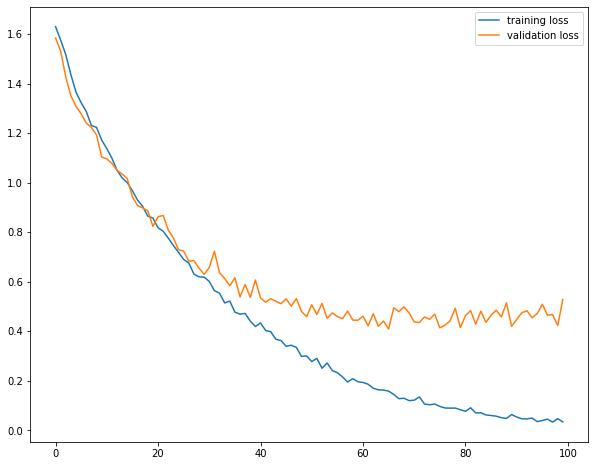

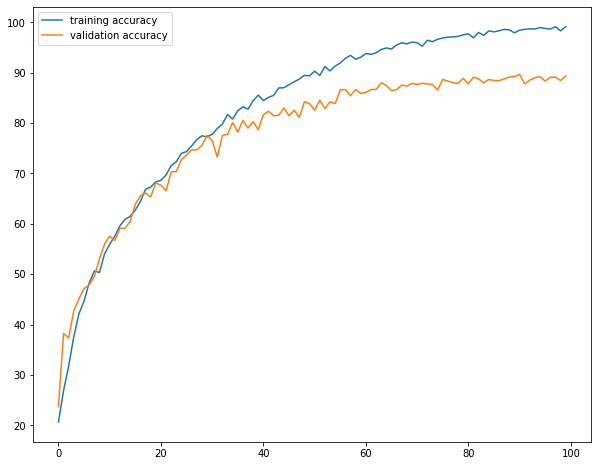

In [12]:
net1, c1, o1 = gen_net(lr=0.0001)
tl1, vl1, ta1, va1 = training(net1, c1, o1, *cross_val_folds[0])

In [13]:
for i, (items, classes) in enumerate(test_loader):
  # Convert torch tensor to Variable
  items = Variable(items)
  classes = Variable(classes)
  
  # If we have GPU, shift the data to GPU
  if cuda.is_available():
      items = items.cuda()
      classes = classes.cuda()

  outputs = net1(items.float())      # Do the forward pass
  print(outputs[0])
  print(classes[0])
  break

tensor([  0.2208,  -9.5968,  14.2545,   8.0614, -12.0320], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(2, device='cuda:0')


In [14]:
torch.save(net1.state_dict(), './alex_net_1_f1.pth')

In [15]:
import numpy as np
np.save('net1_f1_loss_acc', [
  [float(tl.cpu()) for tl in tl1], 
  [float(vl.cpu()) for vl in vl1], 
  [float(ta.cpu()) for ta in ta1], 
  [float(va.cpu()) for va in va1], 
])

cuda is_available
 90/90 Epoch 1/100, Tr Loss: 1.6019, Tr Acc: 23.8333, Val Loss: 1.4896, Val Acc: 33.5556
 90/90 Epoch 2/100, Tr Loss: 1.4747, Tr Acc: 34.5278, Val Loss: 1.2913, Val Acc: 47.4444
 90/90 Epoch 3/100, Tr Loss: 1.2923, Tr Acc: 46.5000, Val Loss: 1.1500, Val Acc: 54.7778
 90/90 Epoch 4/100, Tr Loss: 1.1279, Tr Acc: 55.0556, Val Loss: 1.0837, Val Acc: 54.5556
 90/90 Epoch 5/100, Tr Loss: 1.0001, Tr Acc: 60.6111, Val Loss: 0.9752, Val Acc: 59.8889
 90/90 Epoch 6/100, Tr Loss: 0.8783, Tr Acc: 66.4444, Val Loss: 0.8736, Val Acc: 67.2222
 90/90 Epoch 7/100, Tr Loss: 0.7962, Tr Acc: 70.4167, Val Loss: 0.6983, Val Acc: 71.7778
 90/90 Epoch 8/100, Tr Loss: 0.6811, Tr Acc: 74.8611, Val Loss: 0.6890, Val Acc: 74.2222
 90/90 Epoch 9/100, Tr Loss: 0.6109, Tr Acc: 77.0833, Val Loss: 0.6183, Val Acc: 77.1111
 90/90 Epoch 10/100, Tr Loss: 0.5252, Tr Acc: 80.2778, Val Loss: 0.5936, Val Acc: 77.6667
 90/90 Epoch 11/100, Tr Loss: 0.4844, Tr Acc: 82.3611, Val Loss: 0.5630, Val Acc: 79.4444
 

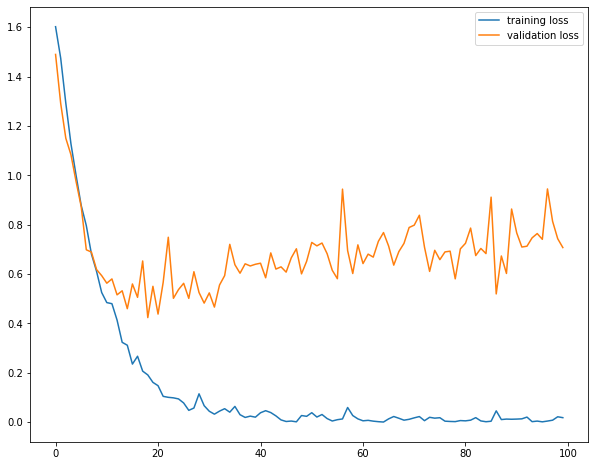

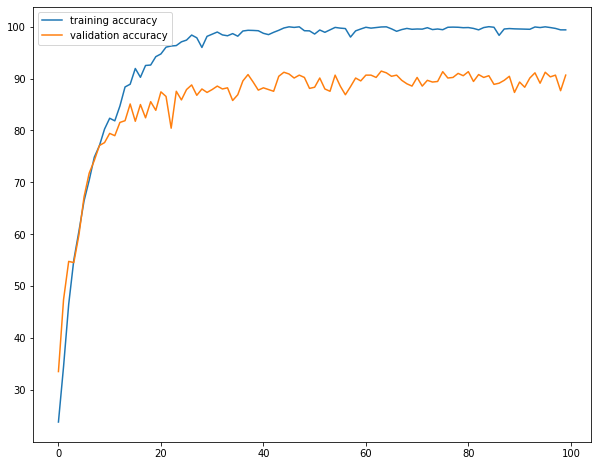

In [16]:
net2, c2, o2 = gen_net()
tl2, vl2, ta2, va2 = training(net2, c2, o2, *cross_val_folds[1])

In [17]:
torch.save(net2.state_dict(), './alex_net_1_f2.pth')
import numpy as np
np.save('net1_f2_loss_acc', [
  [float(tl.cpu()) for tl in tl2], 
  [float(vl.cpu()) for vl in vl2], 
  [float(ta.cpu()) for ta in ta2], 
  [float(va.cpu()) for va in va2], 
])

cuda is_available
 90/90 Epoch 1/100, Tr Loss: 1.6199, Tr Acc: 21.6944, Val Loss: 1.5493, Val Acc: 37.5556
 90/90 Epoch 2/100, Tr Loss: 1.4901, Tr Acc: 32.7222, Val Loss: 1.4271, Val Acc: 39.1111
 90/90 Epoch 3/100, Tr Loss: 1.3377, Tr Acc: 45.6111, Val Loss: 1.3586, Val Acc: 44.0000
 90/90 Epoch 4/100, Tr Loss: 1.1926, Tr Acc: 51.3333, Val Loss: 1.1802, Val Acc: 54.4444
 90/90 Epoch 5/100, Tr Loss: 1.0773, Tr Acc: 57.8889, Val Loss: 0.9347, Val Acc: 64.6667
 90/90 Epoch 6/100, Tr Loss: 0.9360, Tr Acc: 63.9167, Val Loss: 0.8416, Val Acc: 68.8889
 90/90 Epoch 7/100, Tr Loss: 0.8310, Tr Acc: 68.4167, Val Loss: 0.8405, Val Acc: 69.8889
 90/90 Epoch 8/100, Tr Loss: 0.6953, Tr Acc: 72.8611, Val Loss: 0.6757, Val Acc: 74.6667
 90/90 Epoch 9/100, Tr Loss: 0.6146, Tr Acc: 77.3056, Val Loss: 0.6680, Val Acc: 74.8889
 90/90 Epoch 10/100, Tr Loss: 0.5712, Tr Acc: 78.1389, Val Loss: 0.6632, Val Acc: 77.8889
 90/90 Epoch 11/100, Tr Loss: 0.5032, Tr Acc: 80.9444, Val Loss: 0.6389, Val Acc: 74.8889
 

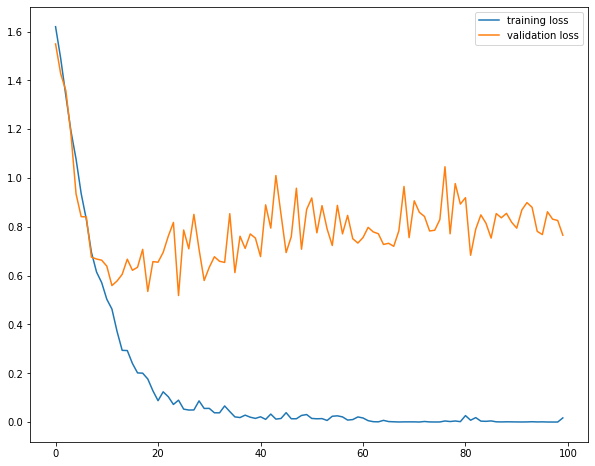

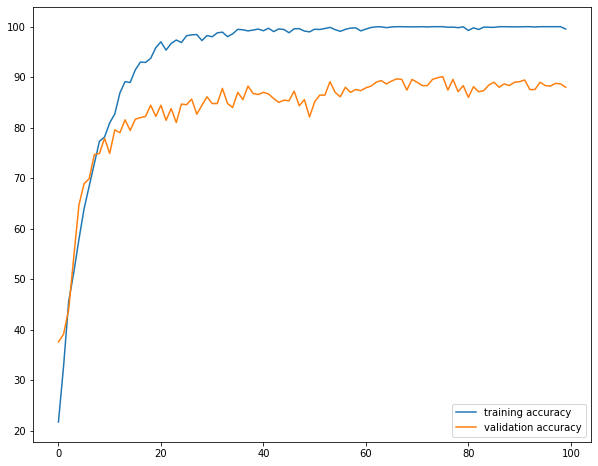

In [18]:
net3, c3, o3 = gen_net()
tl3, vl3, ta3, va3 = training(net3, c3, o3, *cross_val_folds[2])

In [19]:
torch.save(net3.state_dict(), './alex_net_1_f3.pth')
import numpy as np
np.save('net1_f3_loss_acc', [
  [float(tl.cpu()) for tl in tl3], 
  [float(vl.cpu()) for vl in vl3], 
  [float(ta.cpu()) for ta in ta3], 
  [float(va.cpu()) for va in va3], 
])

cuda is_available
 90/90 Epoch 1/100, Tr Loss: 1.6225, Tr Acc: 21.8611, Val Loss: 1.5617, Val Acc: 33.6667
 90/90 Epoch 2/100, Tr Loss: 1.4995, Tr Acc: 32.3889, Val Loss: 1.3972, Val Acc: 40.7778
 90/90 Epoch 3/100, Tr Loss: 1.3364, Tr Acc: 44.0556, Val Loss: 1.3268, Val Acc: 45.3333
 90/90 Epoch 4/100, Tr Loss: 1.2190, Tr Acc: 49.8056, Val Loss: 1.0290, Val Acc: 58.4444
 90/90 Epoch 5/100, Tr Loss: 1.0915, Tr Acc: 56.6111, Val Loss: 0.8874, Val Acc: 66.0000
 90/90 Epoch 6/100, Tr Loss: 0.9416, Tr Acc: 63.4722, Val Loss: 0.7581, Val Acc: 71.8889
 90/90 Epoch 7/100, Tr Loss: 0.8035, Tr Acc: 69.8889, Val Loss: 0.8208, Val Acc: 70.6667
 90/90 Epoch 8/100, Tr Loss: 0.7596, Tr Acc: 70.9444, Val Loss: 0.6790, Val Acc: 74.3333
 90/90 Epoch 9/100, Tr Loss: 0.6424, Tr Acc: 76.0556, Val Loss: 0.5841, Val Acc: 78.2222
 90/90 Epoch 10/100, Tr Loss: 0.5820, Tr Acc: 78.7222, Val Loss: 0.5145, Val Acc: 81.6667
 90/90 Epoch 11/100, Tr Loss: 0.5103, Tr Acc: 80.6667, Val Loss: 0.4882, Val Acc: 82.1111
 

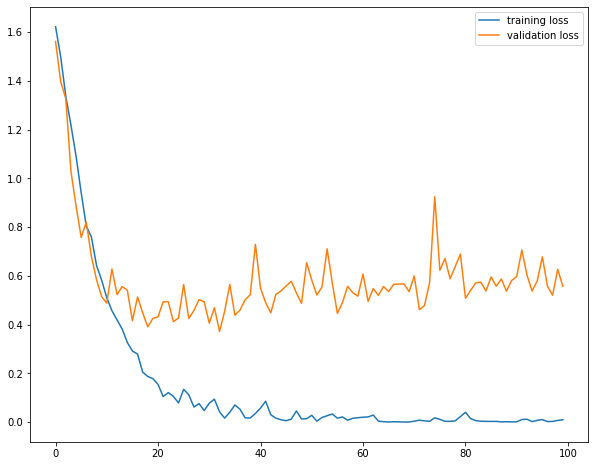

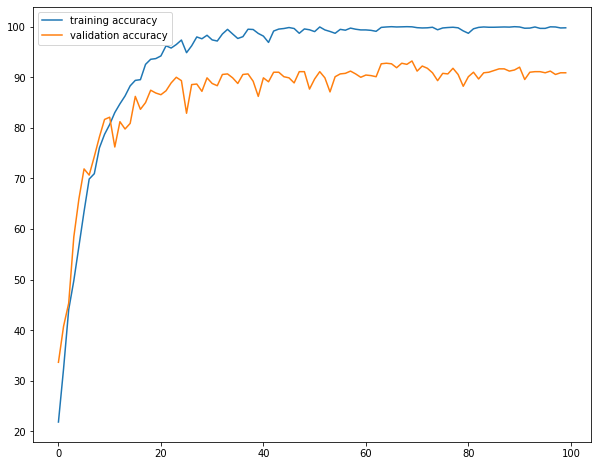

In [20]:
net4, c4, o4 = gen_net()
tl4, vl4, ta4, va4 = training(net4, c4, o4, *cross_val_folds[3])

In [21]:
torch.save(net4.state_dict(), './alex_net_1_f4.pth')
import numpy as np
np.save('net1_f4_loss_acc', [
  [float(tl.cpu()) for tl in tl4], 
  [float(vl.cpu()) for vl in vl4], 
  [float(ta.cpu()) for ta in ta4], 
  [float(va.cpu()) for va in va4], 
])

cuda is_available
 90/90 Epoch 1/100, Tr Loss: 1.6182, Tr Acc: 22.5556, Val Loss: 1.5071, Val Acc: 34.7778
 90/90 Epoch 2/100, Tr Loss: 1.4811, Tr Acc: 34.1944, Val Loss: 1.3140, Val Acc: 41.4444
 90/90 Epoch 3/100, Tr Loss: 1.3452, Tr Acc: 42.7222, Val Loss: 1.2472, Val Acc: 46.7778
 90/90 Epoch 4/100, Tr Loss: 1.2073, Tr Acc: 51.6111, Val Loss: 1.0210, Val Acc: 60.1111
 90/90 Epoch 5/100, Tr Loss: 1.0731, Tr Acc: 56.9167, Val Loss: 0.9368, Val Acc: 64.8889
 90/90 Epoch 6/100, Tr Loss: 0.9330, Tr Acc: 64.1389, Val Loss: 0.8494, Val Acc: 70.0000
 90/90 Epoch 7/100, Tr Loss: 0.8000, Tr Acc: 70.1389, Val Loss: 0.7367, Val Acc: 74.1111
 90/90 Epoch 8/100, Tr Loss: 0.7198, Tr Acc: 72.9722, Val Loss: 0.8317, Val Acc: 68.8889
 90/90 Epoch 9/100, Tr Loss: 0.6078, Tr Acc: 77.2500, Val Loss: 0.6894, Val Acc: 75.6667
 90/90 Epoch 10/100, Tr Loss: 0.5745, Tr Acc: 77.8333, Val Loss: 0.6373, Val Acc: 77.3333
 90/90 Epoch 11/100, Tr Loss: 0.5334, Tr Acc: 80.1944, Val Loss: 0.7832, Val Acc: 71.3333
 

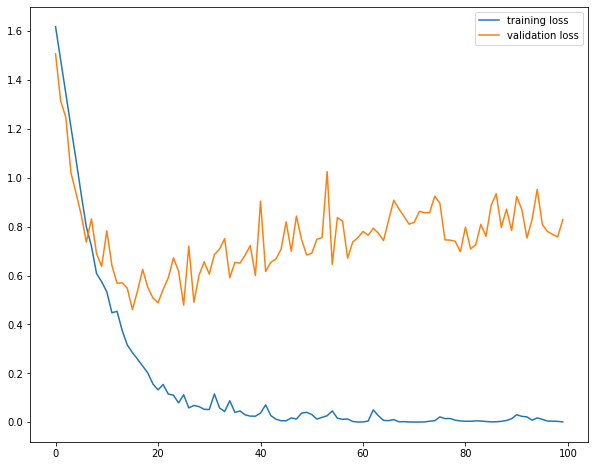

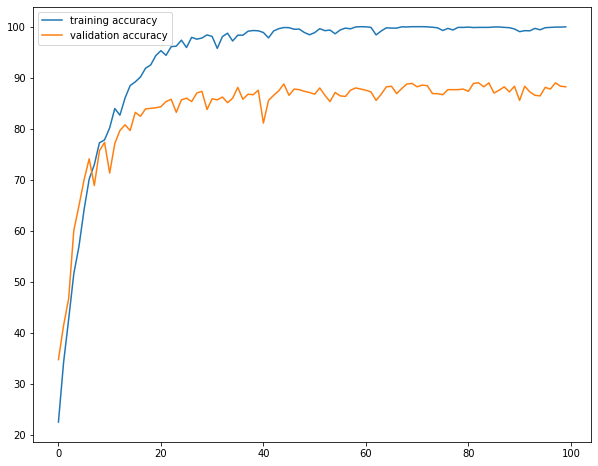

In [22]:
net5, c5, o5 = gen_net()
tl5, vl5, ta5, va5 = training(net5, c5, o5, *cross_val_folds[4])

In [23]:
torch.save(net5.state_dict(), './alex_net_1_f5.pth')
import numpy as np
np.save('net1_f5_loss_acc', [
  [float(tl.cpu()) for tl in tl5], 
  [float(vl.cpu()) for vl in vl5], 
  [float(ta.cpu()) for ta in ta5], 
  [float(va.cpu()) for va in va5], 
])